# Final Project CS209b
## Conditional Autoregression (CAR) Covid & Flu - May 5
### Benjamin Levy, Will Fried, Dimitris Vamvourellis & Matthieu Meeus

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### 1. Get the data

#### 1.1 Flu data

In [39]:
# paths to data
PATH_TO_FLU = 'flu_ground_truth/'
PATH_TO_STATESTATS = 'state_stats.csv'

# open all flu csv files and save them in one dataframe
flu_data = pd.DataFrame()
for filename in os.listdir(PATH_TO_FLU ):
    if flu_data.empty:
        state = filename[13:-4]
        flu_data = pd.read_csv(PATH_TO_FLU  + filename)
        flu_data.rename(columns={"wili": state}, inplace = True)
    else:
        state = filename[13:-4]
        state_data = pd.read_csv(PATH_TO_FLU + filename)
        flu_data[state] = state_data['wili'] 

flu_data.head()

,time,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,2010-40,2.13477,0.875146,0.674721,0.696056,1.95412,0.660684,0.078309,0.100125,2.80877,...,0.274655,2.06514,0.747696,1.47641,0.0001,1.14343,0.510041,1.59741,0.465022,0.632911
1,2010-41,2.05999,1.128270,0.749939,0.674157,2.15266,0.628621,0.238095,0.368550,2.89079,...,0.499492,2.09394,0.410939,1.35777,0.0001,1.23653,1.040070,1.58968,0.581832,0.440621
2,2010-42,1.94224,0.586042,0.953365,0.514217,2.24173,0.804020,0.374158,0.337025,2.41042,...,0.499550,2.10072,0.440583,1.48221,0.0001,1.22545,0.904393,1.52672,1.188220,0.441798
3,2010-43,2.27650,0.967742,0.888804,0.413650,1.91748,0.909658,0.333542,0.460494,3.11632,...,0.401638,2.20655,0.755957,1.44393,0.0001,1.26902,0.955110,1.81171,1.010490,0.490305
4,2010-44,2.83371,0.683851,1.185730,1.090280,2.52326,0.971705,0.396743,0.222332,2.99118,...,0.528096,2.36381,0.651859,1.25276,0.0001,1.26547,0.786370,1.83986,1.096490,0.566636


In [41]:
# check the NaN
nans = []
for state_name in flu_data.columns:
    if state_name != 'time':
        nans_state = flu_data[state_name].isna().sum()
        if nans_state != 0:
            print('For {}, there are {} NaNs'.format(state_name, nans_state))
        nans.append(nans_state)

For Puerto Rico, there are 156 NaNs
For Virgin Islands, there are 52 NaNs


In [43]:
# As these states contain NaNs and are not so relevant, 
# we might as well get rid of them
flu_data.drop(['Puerto Rico', 'Virgin Islands'], axis = 1, inplace = True)

#### 1.2 State data

In [7]:
state_data = pd.read_csv(PATH_TO_STATESTATS)
state_data.head()

,density_metric,Latitude,is_coastal,airport_arrivals,Children 0-18,Adults 19-25,Adults 26-34,Adults 35-54,Adults 55-64,65+,...,ID_is_neighbor,ME_is_neighbor,MS_is_neighbor,VT_is_neighbor,SD_is_neighbor,ND_is_neighbor,MT_is_neighbor,WY_is_neighbor,overall_vacc_rate,child_vacc_rate
NY,10711.4,40.705626,1,2.625045,0.22,0.09,0.13,0.26,0.14,0.16,...,0,0,0,1,0,0,0,0,81.7,69.6
NJ,2789.6,40.143006,1,2.333070,0.23,0.08,0.11,0.27,0.14,0.16,...,0,0,0,0,0,0,0,0,79.4,72.8
PA,1957.6,40.994593,1,1.621257,0.22,0.08,0.12,0.25,0.14,0.18,...,0,0,0,0,0,0,0,0,82.5,69.7
IL,1761.9,39.739318,0,4.102417,0.24,0.09,0.12,0.26,0.13,0.15,...,0,0,0,0,0,0,0,0,83.0,60.1
MD,1737.6,38.806352,1,2.316047,0.23,0.08,0.12,0.27,0.14,0.15,...,0,0,0,0,0,0,0,0,81.9,74.5


In [21]:
# create a dictionary of state names to 2 letter abbreviations and back
state_name2abbrev = {
    'Alabama':'AL','Alaska':'AK','Arizona':'AZ','Arkansas':'AR','California':'CA', 
    'Colorado':'CO','Connecticut':'CT','Delaware':'DE','Florida':'FL','Georgia':'GA',
    'Hawaii':'HI','Idaho':'ID','Illinois':'IL','Indiana':'IN','Iowa':'IA','Kansas':'KS',
    'Kentucky':'KY','Louisiana':'LA','Maine':'ME','Maryland':'MD','Massachusetts':'MA',
    'Michigan':'MI','Minnesota':'MN','Mississippi':'MS','Missouri':'MO','Montana':'MT',
    'Nebraska':'NE','Nevada':'NV','New Hampshire':'NH','New Jersey':'NJ','New Mexico':'NM',
    'New York':'NY','North Carolina':'NC','North Dakota':'ND','Ohio':'OH','Oklahoma':'OK',
    'Oregon':'OR','Pennsylvania':'PA','Rhode Island':'RI','South Carolina':'SC',
    'South Dakota':'SD','Tennessee':'TN','Texas':'TX','Utah':'UT','Vermont':'VT',
    'Virginia':'VA','Washington':'WA','West Virginia':'WV','Wisconsin':'WI','Wyoming':'WY'
}

state_abbrev2name = {state_name2abbrev[name]:name for name in state_name2abbrev.keys()}

for state in flu_data.columns:
    if state not in state_name2abbrev.keys() and state != 'time':
        print(state)
print('------------')
for state in state_data.index.values:
    if state not in state_name2abbrev.values():
        print(state)
print('------------')
for state in state_name2abbrev.values():
    if state not in state_data.index.values:
        print(state)

District of Columbia
New York City
Puerto Rico
Virgin Islands
------------
------------
AK
HI


#### 1.3 Covid data

Source: https://data.humdata.org/dataset/nyt-covid-19-data

In [134]:
PATH_TO_COVID = 'us-states.csv'
covid_data_source = pd.read_csv(PATH_TO_COVID)
covid_data_source.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [135]:
unique_states = covid_data_source['state'].unique()
unique_states.sort()
unique_states

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [136]:
df = pd.DataFrame({'date': covid_data_source.date.unique()})

for state in unique_states:
    state_df = covid_data_source.loc[covid_data_source['state'] == state]
    state_df = state_df[['date', 'cases']]
    df = df.merge(state_df, how = 'left', left_on = 'date', right_on = 'date')
    df = df.rename({'cases':state}, axis = 1)

covid_data = df
print('Start of pandemic in US:')
print(covid_data.head())
print('Most recent datapoint in US:')
print(covid_data.tail())

Start of pandemic in US:
         date  Alabama  Alaska  Arizona  Arkansas  California  Colorado  \
0  2020-01-21      NaN     NaN      NaN       NaN         NaN       NaN   
1  2020-01-22      NaN     NaN      NaN       NaN         NaN       NaN   
2  2020-01-23      NaN     NaN      NaN       NaN         NaN       NaN   
3  2020-01-24      NaN     NaN      NaN       NaN         NaN       NaN   
4  2020-01-25      NaN     NaN      NaN       NaN         1.0       NaN   

   Connecticut  Delaware  District of Columbia  ...  Tennessee  Texas  Utah  \
0          NaN       NaN                   NaN  ...        NaN    NaN   NaN   
1          NaN       NaN                   NaN  ...        NaN    NaN   NaN   
2          NaN       NaN                   NaN  ...        NaN    NaN   NaN   
3          NaN       NaN                   NaN  ...        NaN    NaN   NaN   
4          NaN       NaN                   NaN  ...        NaN    NaN   NaN   

   Vermont  Virgin Islands  Virginia  Washington 

In [141]:
covid_data.to_csv('Covid_data.csv')

Text(0.5, 1.0, 'Covid-19 cases per US state over time')

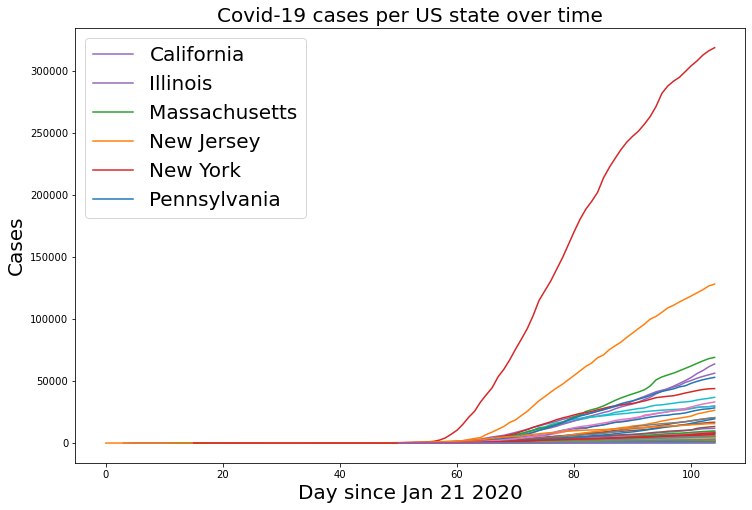

In [146]:
plt.figure(figsize = (12,8))
for state_name in covid_data.columns:
    if state_name != 'date':
        if covid_data[state_name].values[-1]>50000:
            plt.plot(range(len(covid_data)), covid_data[state_name], label = state_name)
        else:
            plt.plot(range(len(covid_data)), covid_data[state_name])
plt.xlabel('Day since Jan 21 2020', fontsize = 20)
plt.ylabel('Cases', fontsize = 20)
plt.legend(fontsize = 20)
plt.title('Covid-19 cases per US state over time', fontsize = 20)

### 2. Conditional Autoregression: Theory

#### 2.1 General CAR

We will first discuss the conditional autoregressive (CAR) model in general. It is widely used to model the spatial variation of the response variable $y_i$, where it is assumed that the probability of values estimated for a variable $z_i$ are conditional on neighboring values $z_j$. As such, it is a natural way to study the spatial relations present in specific data. It is thus potentially interesting to apply a CAR model to our geographically spread data on deseases. 

Consider a general Spatial Regression Model (SAR) to start with:

$$y_i = X_i\beta + z_i + \epsilon_i$$

Where:

- $y_i$ is the response variable at node i, 
- $X_i$ the predictor variables measured at the same node as $y_i$, 
- $\beta$ the regression coefficients,
- $z_i$ a latent spatial random error $z_i \sim N(0, \Sigma_i)$,
- $\epsilon_i$ an independent error $\epsilon_i \sim N(0, \sigma_{\epsilon_i}^2)$

In the Conditional AR model, the $z_i$ variable depends on the neighbouring values $z_j$ for $i \neq j$:

$$z_i | z_j, i \neq j \sim N(\sum_{j \neq i} c_{ij} z_j, m_{ii})$$

Where $c_{ii} = 0$. As such, there are three main contributions to the response variable $y_i$: a regression of locally measured predictors, a conditional spatial term and a random error that is specific to the location. The matrix $C$ is often developed as $\rho W$ where $W$ is the 'neighborhood matrix' and $\rho$ an autocorelation factor. 

Reference to: https://eprints.qut.edu.au/115891/1/115891.pdf

#### 2.2 CAR applied to time series of state-dependent desease rate

We will now try to embed the idea of CAR in our time series model. How I see it at this point:

$$Y_{ti} = \beta X_i + z_i + \epsilon_i$$

Where:

- $Y_{ti}$ is for instace the Wili rate in state i at time t. We still want to predict the response variable over time at a specific location, so this remains the response variable. 
- $X_i$ is a vector containing all the 'local' predictors. In the case of a AR time series model, this will contain the N previous Wili observations in time in state i.
- $\beta$ is a vector containing the local AR time-lag-regression coefficients. 
- $z_i$ is the latent spatial random error, which will be conditional on the neighbouring states, where neighbour still needs to be defined. 
- $\epsilon_i$ an independent error $\epsilon_i \sim N(0, \sigma_{\epsilon_i}^2)$

Now some more design decisions need to be made. 

First, distribution of the data? What would be reasonable? 

Next, we need to decide whether $\beta$ will be state-specific or not. This comes down to the choice of sampling $\beta_i$ from a normal distribution for each state separately $\beta_i \sim N(0, \sigma^2)$ with $\frac{1}{\sigma^2} \sim Gamma(0.1, 0.1)$ or considering one vector $\beta$ for all states $\beta_i \sim N(0, \sigma^2)$. I would argue that we want this to be state-independent as we hope to account for the state differences/similarities in the $z_i$.

Second, we need to dive into the specifics of $z_i$. Recall:

$$z_i | z_j, i \neq j \sim N(\sum_{j \neq i} c_{ij} z_j, m_{ii})$$

And following standard practice, we can define the matrix $C = \rho W$. Now it comes down to come up with a reasonable value for the correlation variable $\rho$ and the construction of neighbor matrix $W$. 

One option is to start with the actual neighboring values (0 or 1) and a constant correlation variable. Another would be to come up with a W that incorporates (a clever selection of) the features we have. For instance a weighted combination of relative difference in population density and temperature. 

Another would be to model $c_{ij}$ based on all the features we have, in a similar fashion as Will's model:

$$c_{ij} = \beta_0 + \beta_1I_{neighbor} + \beta_2|density_i - density_j| \ + \beta_3*commute_{ij} \ + ... + \ \beta_k|summer\_temp_i - summer\_temp_j|*I(season = summer)$$

This would enable us to get an understanding of the feature importance. Or does this get too complicated? 

#### 2.3 Final model decision

The initial idea was to apply the CAR model to the flu, where the weights of the neighbour matrix W would be drawn from a distribution that depends on the state statistics. However, we realized that:
- this would be tricky to fit using PyMC3 and that 
- this is not the goal of CAR models, as the 'neighbour' characteristic should be intrinsic to the problem.  

As such, it would make more sense to use the model with clever, fixed values for the coefficients in W. That's where the flu data can leveraged in modeling Covid! We will use the 10 years of Wili data in all states to come up with a reasonable construction of W, capturing the definition of 'neighbour' for all states in the context of the spread of a desease. We will then be able to use this fixed W to model state-specific spread of Covid-19 for all US states. 

### 3. Building the model

There will be two big steps here: 
- Construct W using the flu data. 
- Build the CAR model for Covid using this W

Nice resource: https://docs.pymc.io/notebooks/PyMC3_tips_and_heuristic.html

#### 3.1 Construct W

How does one capture the similarity between different states for a set of time series? The first thing that comes to mind is correlation! Let's start by constructing W with

$$w_{ij} = \rho_{ij}$$

Where $\rho_{ij}$ corresponds to the correlation of the 10 year time series of state i with the 10 year time series of state j. 

In [80]:
# this comes down to the following:
corr_df = flu_data.corr()
W_0 = corr_df.values
corr_df

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Alabama,1.000000,0.391694,0.478343,0.804513,0.745767,0.497752,0.476991,0.575632,0.291254,0.736040,...,0.683622,0.777976,0.742456,0.558684,0.477707,0.725261,0.657446,0.733572,0.644852,0.669490
Alaska,0.391694,1.000000,0.666329,0.602480,0.382889,0.622718,0.634617,0.426205,-0.064847,0.611873,...,0.621883,0.537671,0.596218,0.384331,0.358817,0.659558,0.506154,0.587236,0.567312,0.699456
Arizona,0.478343,0.666329,1.000000,0.709991,0.624341,0.654745,0.811796,0.498348,0.054434,0.647942,...,0.705905,0.606587,0.730329,0.512183,0.473540,0.679351,0.648756,0.714140,0.693408,0.755366
Arkansas,0.804513,0.602480,0.709991,1.000000,0.751528,0.679171,0.725066,0.693146,0.301509,0.746748,...,0.825016,0.845184,0.885197,0.604639,0.590707,0.847871,0.752724,0.882349,0.789971,0.820662
California,0.745767,0.382889,0.624341,0.751528,1.000000,0.558097,0.547916,0.675913,0.297370,0.549149,...,0.727427,0.652471,0.698371,0.677356,0.685538,0.673084,0.822578,0.744080,0.644153,0.692804
Colorado,0.497752,0.622718,0.654745,0.679171,0.558097,1.000000,0.682697,0.529165,0.062064,0.612561,...,0.546462,0.624606,0.683840,0.717153,0.507250,0.737585,0.637631,0.696294,0.593628,0.696232
Connecticut,0.476991,0.634617,0.811796,0.725066,0.547916,0.682697,1.000000,0.566047,0.205673,0.656959,...,0.730742,0.642900,0.744177,0.551116,0.554587,0.757633,0.600053,0.746732,0.754646,0.762843
Delaware,0.575632,0.426205,0.498348,0.693146,0.675913,0.529165,0.566047,1.000000,0.315159,0.526677,...,0.647567,0.641777,0.654674,0.619825,0.747338,0.756916,0.638499,0.702503,0.602785,0.738004
District of Columbia,0.291254,-0.064847,0.054434,0.301509,0.297370,0.062064,0.205673,0.315159,1.000000,0.099387,...,0.225659,0.402648,0.358585,0.364596,0.283210,0.308540,0.209442,0.289540,0.344149,0.159778
Georgia,0.736040,0.611873,0.647942,0.746748,0.549149,0.612561,0.656959,0.526677,0.099387,1.000000,...,0.706272,0.745300,0.776738,0.412747,0.370283,0.795916,0.579545,0.706390,0.663983,0.750493


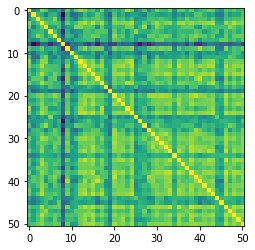

In [81]:
plt.imshow(W_0)

Although the correlation would make sense as weight between states, we would miss out on an important aspect of the definition of 'neighbour', being that a state can only have a limited amount of neighbours. So ideally, we wish to make W a sparse matrix, where only the coefficients corresponding to the highest correlation between states i and j are non-zero. 

Driving the least important coefficients to exactly zero sounds like a LASSO! So let's build a plain vanilla linear regression model for each state's time series, using all the other states as predictors. We'll fit the model using a strong $l_1$-regularization, which will lead to only a limited amount of non-zero coefficients. Note that the Lasso Sklearn implementation has an attribute 'positive' which makes sure the model only considers positive values for the coefficients. 

In [82]:
from sklearn.linear_model import Lasso

lamb = 0.01
N = len(flu_data.columns[1:])
W = np.zeros((N,N))

for i, state_name in enumerate(flu_data.columns[1:]):
    y = flu_data[state_name].values
    df_to_work_with = flu_data.drop(['time', state_name], axis = 1)
    X = df_to_work_with.values
    lasso_obj = Lasso(alpha = lamb, positive = True)
    lasso_obj.fit(X,y)
    coef = lasso_obj.coef_
    left = coef[:i]
    right = coef[i:]
    W[i,:i] = left
    W[i, i+1:] = right

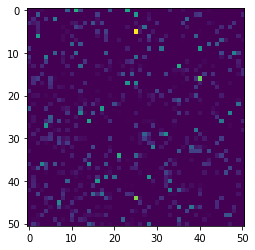

In [83]:
plt.imshow(W)

In [95]:
# let's check the results and compare to the correlation

for i, state_name in enumerate(flu_data.columns[1:][:5]):
    neighbors = []
    coefs = []
    for k, coef in enumerate(W[i,:]):
        if coef > 0:
            coefs.append(coef)
            neighbors.append(flu_data.columns[1:][k])
    n_neigh = len(neighbors)
    max_coefs = np.array(coefs).argsort()[::-1][1:n_neigh+1]
    neighbors = np.array(neighbors)[max_coefs]
    print('For state {}, the identified neighbours are: '.format(state_name))
    print(list(neighbors))
    # let's compare to the states with the highest correlation
    corr_list = W_0[i, :].copy()
    max_coefs = corr_list.argsort()[::-1][1:n_neigh+1]
    max_corr_states = flu_data.columns[1:][max_coefs]
    print('The max correlation states were: ')
    print(list(max_corr_states))
    print('------------')

For state Alabama, the identified neighbours are: 
['Mississippi', 'Georgia', 'Maryland', 'Illinois', 'North Carolina', 'Oklahoma', 'Arkansas', 'Tennessee']
The max correlation states were: 
['Mississippi', 'Illinois', 'Arkansas', 'Indiana', 'Louisiana', 'Tennessee', 'Missouri', 'New Mexico', 'North Carolina']
------------
For state Alaska, the identified neighbours are: 
['Arizona', 'Kentucky', 'South Carolina', 'Rhode Island', 'Wyoming', 'New Hampshire']
The max correlation states were: 
['Kentucky', 'South Carolina', 'Rhode Island', 'Wyoming', 'Massachusetts', 'Arizona', 'Virginia']
------------
For state Arizona, the identified neighbours are: 
['Oregon', 'California', 'Alaska', 'New Hampshire', 'Kentucky']
The max correlation states were: 
['Connecticut', 'Massachusetts', 'Oregon', 'Wyoming', 'Kentucky', 'Texas']
------------
For state Arkansas, the identified neighbours are: 
['Louisiana', 'Oklahoma', 'West Virginia', 'Indiana', 'Alabama', 'New Mexico', 'Arizona', 'Montana', 'Ida

Clearly, the states returned by Lasso only match to a limited extent with the max correlation states. I would still believe that the Lasso coefficients capture some truth and they are sparse, so I'd go for these. 

Alternatively, we could just take the states with the highest correlation and put the other coefficients equal to zero. 

--- CHOICE TO MAKE ---

#### 3.2 CAR model for Covid

Let's formalize the final model:

$$Y_{ti} = \beta X_i + z_i + \epsilon_i$$

Where:

- $Y_{ti}$ is  in state i at time t. We still want to predict the response variable over time at a specific location, so this remains the response variable. 
- $X_i$ is a vector containing all the 'local' predictors. In the case of a AR time series model, this will contain the N previous case counts observations in time in state i.
- $\beta$ is a vector containing the local AR time-lag-regression coefficients. To be 
- $z_i$ is the latent spatial random error, which will be conditional on the neighbouring states, where neighbour still needs to be defined. 
- $\epsilon_i$ an independent error $\epsilon_i \sim N(0, \sigma_{\epsilon_i}^2)$

Now some more design decisions need to be made. 

In [26]:
import pymc3 as pm
from theano import shared, scan
import theano
import theano.tensor as tt
from pymc3.distributions import continuous
from pymc3.distributions import distribution
floatX = "float32"

In [27]:
class CAR(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution

    Parameters
    ----------
    a : list of adjacency information
    w : list of weight information
    tau : precision at each location
    """
    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.

    def get_mu(self, x):

        def weigth_mu(w, a):
            a1 = tt.cast(a, 'int32')
            return tt.sum(w*x[a1])/tt.sum(w)

        mu_w, _ = scan(fn=weigth_mu,
                       sequences=[self.w, self.a])

        return mu_w

    def logp(self, x):
        mu_w = self.get_mu(x)
        tau = self.tau
        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))